# STAT 551
# Man Chong (Henry) Leong
# Vignette 1 - Spatial dependence and visualization for polygon level data - of House Hold Income in Harris County

## Goal

Living in Houston, we all know that there are some segregations for residents with different economic status. For example, people making more money will live in the areas of which the hosing price is higher, and vice versa.

Can we make sure whether this phenomenon exists? This question can be answered by using some methods in spatial statistics.


First of all, the census dataset we are using here is from https://www.kinderudp.org/.

In [58]:
rm(list=ls())
library("rgdal")
library("dplyr")
library("data.table")
library("gstat")
library("tidyr")
library("spgwr")
library("spdep")
library("ggplot2")

# read datasets
censusData_bg <- data.table::fread("/Users/manchongleong/Desktop/STAT551/Curated/Cen2010Harris_BG_v01.csv",
                    colClasses = c(GeoID10_bg="chatacher",
                                   stfips="character",
                                   county="character",
                                   tract="character")) %>%
  dplyr::rename(GEOID10=GeoID10_bg)
# read census boundary
censusBoundary <- rgdal::readOGR(dsn="/Users/manchongleong/Desktop/STAT551/", 
                          layer="tl_2010_48_bg10")
# only get the records in Harris County
censusBoundary.harris <- censusBoundary[grepl(c("201"),
                                      censusBoundary@data$COUNTYFP10), ]


OGR data source with driver: ESRI Shapefile 
Source: "/Users/manchongleong/Desktop/STAT551", layer: "tl_2010_48_bg10"
with 15811 features
It has 15 fields
Integer64 fields read as strings:  OBJECTID 


The dataset we are using here is 2010 census data in blockgroup level.

In [59]:
# merge boundary with census data
censusBoundary.harris <- censusBoundary.harris %>%
  merge(censusData_bg, by="GEOID10")

censusBoundary.harris@data$id <- rownames(censusBoundary.harris@data)

# remove na
censusBoundary.harris_clean <- censusBoundary.harris[!(is.na(censusBoundary.harris@data$MedHHinc)), ]

# might have outliers, create another dataset without outlier
# outside 1.5 times the interquartile 
# range above the upper quartile and bellow the lower quartile
censusBoundary.harris_clean_rm_ol <- censusBoundary.harris_clean[!(censusBoundary.harris_clean@data$MedHHinc %in% boxplot(censusBoundary.harris_clean@data$MedHHinc, plot=FALSE)$out), ]



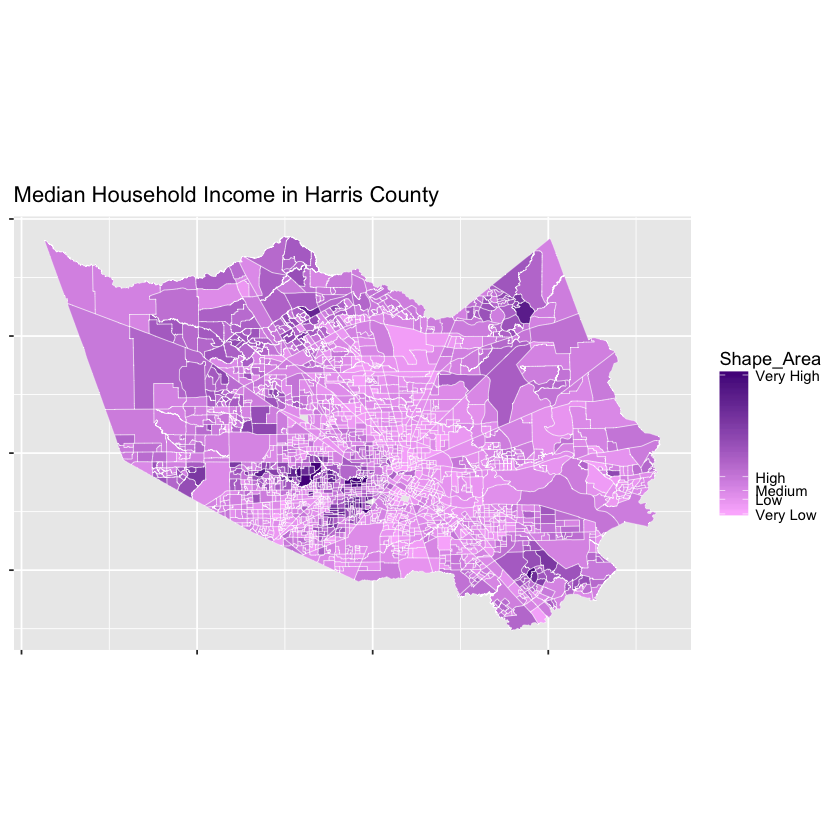

In [61]:
# convert a spatial object into data.frame
HarrisCty.tidy <- ggplot2::fortify(censusBoundary.harris_clean, region="id")

HarrisCty.tidy_merge <- merge(HarrisCty.tidy, censusBoundary.harris_clean@data, by="id")

map_HarrisCty <- ggplot(data=HarrisCty.tidy_merge, aes(long,lat,group=group,fill=MedHHinc)) + 
  geom_polygon() +
  geom_path(color = "white", size=0.1) +
  scale_fill_gradient(low = "plum1", high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean@data$MedHHinc),
                     labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  coord_equal() +
  theme(axis.title = element_blank(), axis.text = element_blank()) +
  labs(title = "Median Household Income in Harris County", fill = "Median Household Income")

map_HarrisCty

Except for couple blockgroups, the colors of the others are so light! Seems like the Median Household income in those outliers are far higher than the others.

We can check it with boxplot.

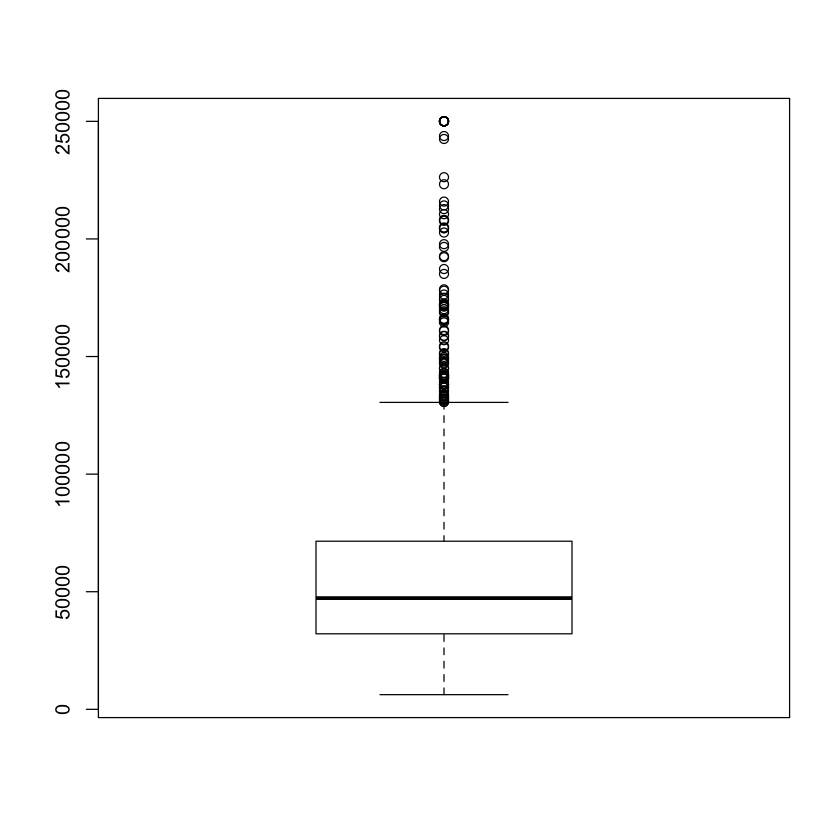

In [65]:
boxplot(censusBoundary.harris_clean@data$MedHHinc)

What happens if we remove the outliers and make the map again?

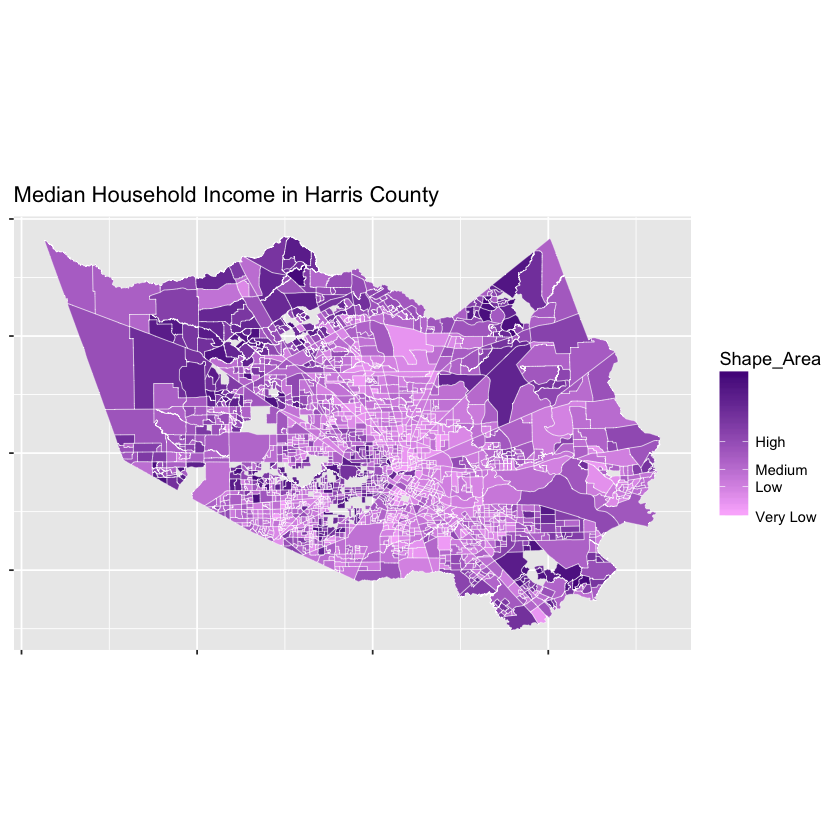

In [66]:
# convert a spatial object into data.frame
HarrisCty.tidy_rm_ot <- ggplot2::fortify(censusBoundary.harris_clean_rm_ol, region="id")

HarrisCty.tidy_rm_ot_merge <- merge(HarrisCty.tidy_rm_ot, censusBoundary.harris_clean_rm_ol@data, by="id")

map_HarrisCty_rm_ot_merge <- ggplot(data=HarrisCty.tidy_rm_ot_merge, aes(long,lat,group=group,fill=MedHHinc)) + 
  geom_polygon() +
  geom_path(color = "white", size=0.1) +
  scale_fill_gradient(low = "plum1", high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean@data$MedHHinc),
                      labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  coord_equal() +
  theme(axis.title = element_blank(), axis.text = element_blank()) +
  labs(title = "Median Household Income in Harris County", fill = "Median Household Income")

map_HarrisCty_rm_ot_merge

The map looks more colorful after removing outliers! Here, we are using the same breaks for the two maps. The "high" value becomes much higher in the second plot.

And very clearly, there are some spatial patterns in both the two maps!

## Using Variogram to check spatial patterns

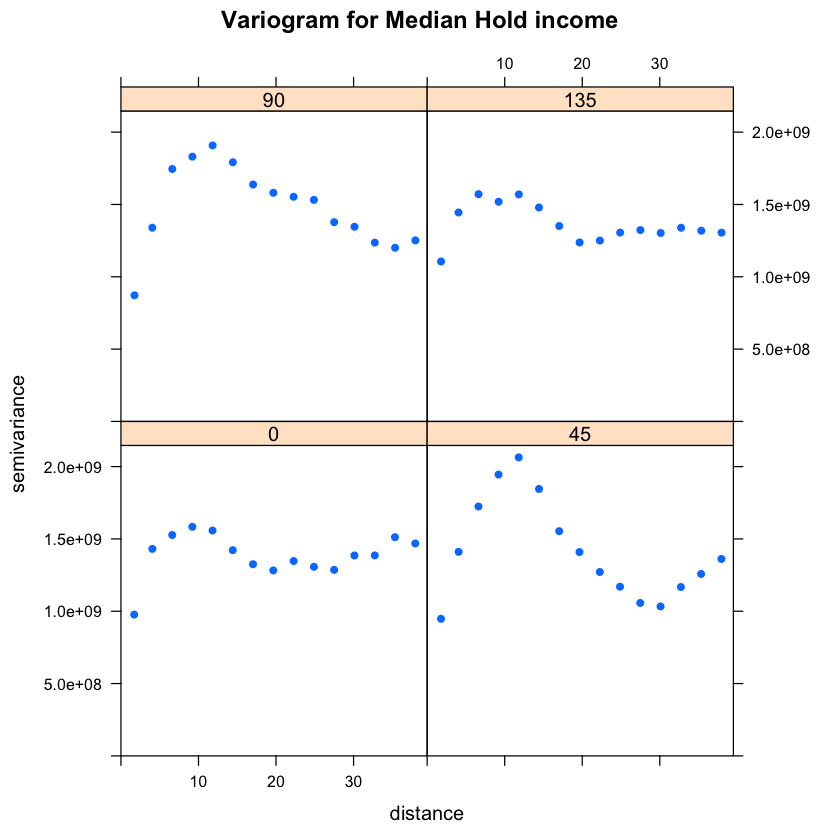

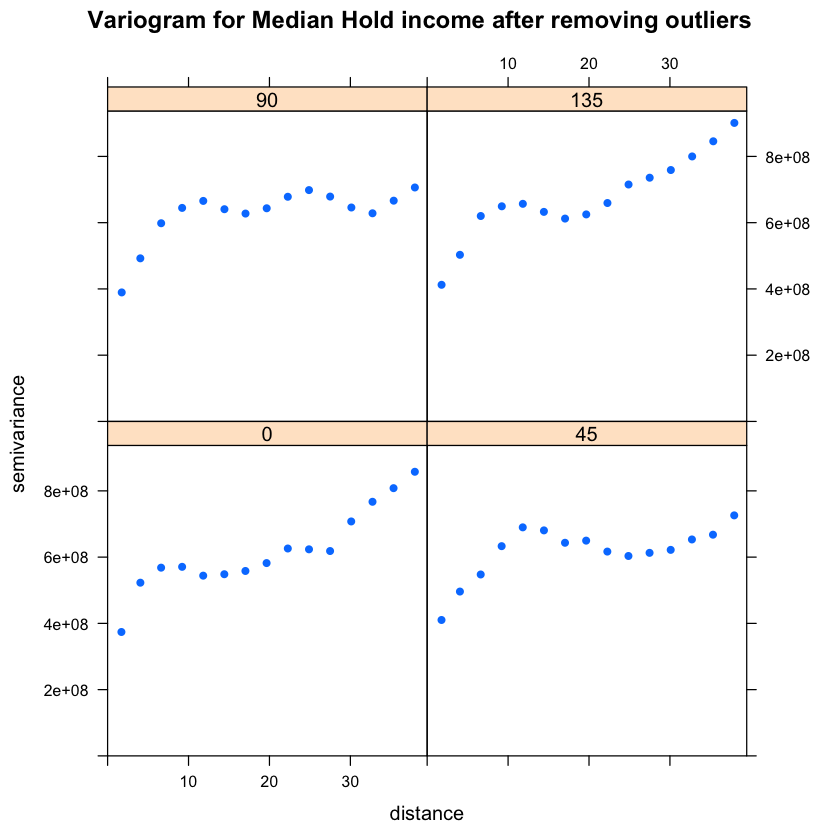

In [69]:
## variogram 
harris_vgm <- gstat::variogram(MedHHinc~1, censusBoundary.harris_clean, alpha = c(0, 45, 90, 135))
harris_vgm_rm_ol <- gstat::variogram(MedHHinc~1, censusBoundary.harris_clean_rm_ol, alpha = c(0, 45, 90, 135))

#census_grid <- sp::spsample(x=censusBoundary, bb=bbox_census, 10000, type="regular")
#plot(MedHHinc_vgm_cloud, main = "Variogram Cloud for MedHHinc", pch = 16)

#Hisp_vgm <- gstat::variogram(Hisp~long+lat, censusBoundary.harris)
plot(harris_vgm, main = "Variogram for Median Hold income", pch = 16)
plot(harris_vgm_rm_ol, main = "Variogram for Median Hold income after removing outliers", pch = 16)



Checking for anisotropy, we change direction in plane (x,y) in positive (0, 45, 90, 135) degrees clockwise from positive y (North). Obviously, direction in plane (x,y) actually matters for variogram of Median Household Income. 

As we can see in the Y-axis, the scale is very large. Would the variogram change rapidly if we change the scale?

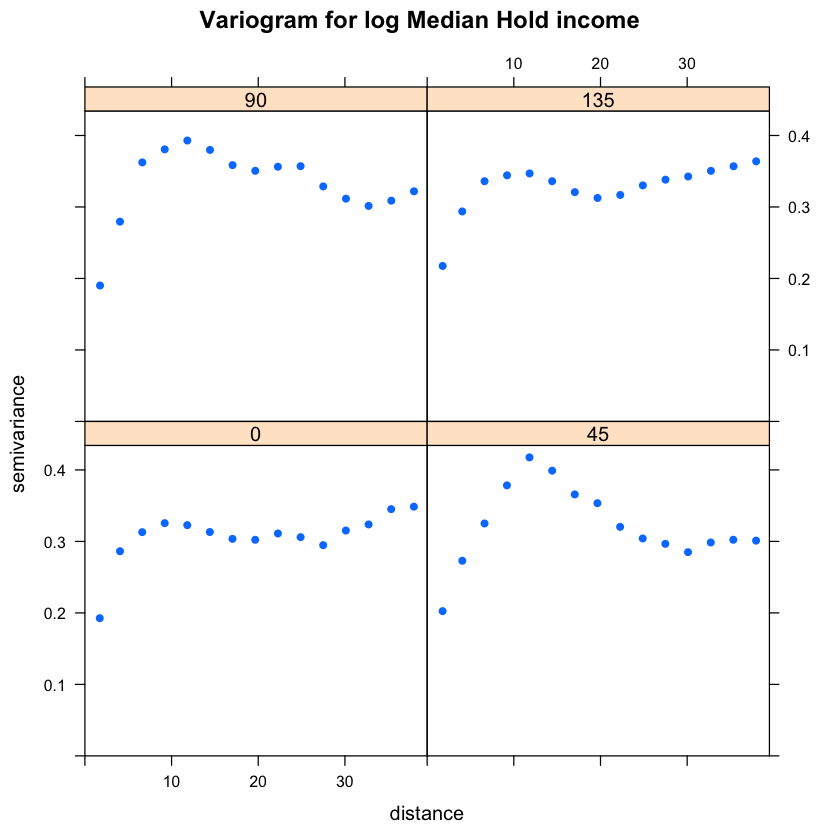

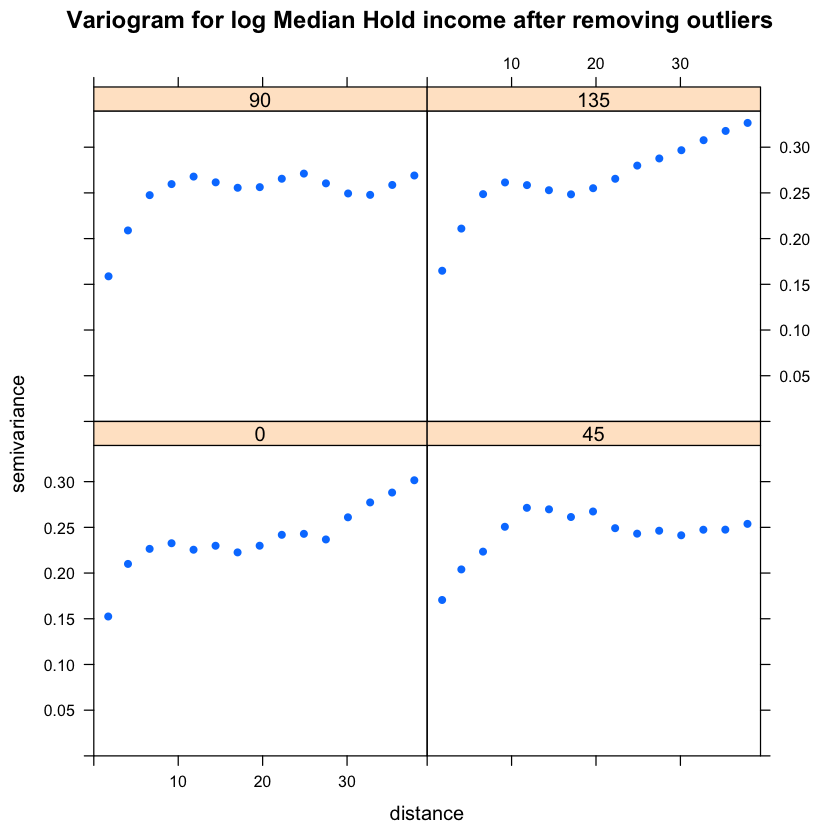

In [71]:
## variogram 
harris_vgm <- gstat::variogram(log(MedHHinc)~1, censusBoundary.harris_clean, alpha = c(0, 45, 90, 135))
harris_vgm_rm_ol <- gstat::variogram(log(MedHHinc)~1, censusBoundary.harris_clean_rm_ol, alpha = c(0, 45, 90, 135))

#census_grid <- sp::spsample(x=censusBoundary, bb=bbox_census, 10000, type="regular")
#plot(MedHHinc_vgm_cloud, main = "Variogram Cloud for MedHHinc", pch = 16)

#Hisp_vgm <- gstat::variogram(Hisp~long+lat, censusBoundary.harris)
plot(harris_vgm, main = "Variogram for log Median Hold income", pch = 16)
plot(harris_vgm_rm_ol, main = "Variogram for log Median Hold income after removing outliers", pch = 16)



Changing the scale, the shapes do change a little bit. Based on these plots, after removing outliers, the spatial patterns are easiest to interpret with changing direction in plane (x,y) in positive 45 or 90 degrees clockwise from positive y (North).

## Statistical tests for spatial dependence

Using Moran I test and Geary C test, we can test whether the observations are spatially independent or not. 

H0: There is no spatial clustering of the values associated with the geographic features.

H1: There is spatial clustering of the values associated with the geographic features.

In [14]:
censusBoundary_nb <- spdep::poly2nb(censusBoundary.harris)
censusBoundary_listw <- spdep::nb2listw(censusBoundary_nb, style = "W", zero.policy=T)

spdep::moran.test(censusBoundary.harris@data$MedHHinc, 
           censusBoundary_listw, 
           zero.policy = T) 
spdep::geary.test(censusBoundary.harris@data$MedHHinc, 
           censusBoundary_listw, 
           zero.policy = T) 


	Moran I test under randomisation

data:  censusBoundary.harris@data$MedHHinc  
weights: censusBoundary_listw    

Moran I statistic standard deviate = 41.376, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.5356437064     -0.0004909180      0.0001679005 



	Geary C test under randomisation

data:  censusBoundary.harris@data$MedHHinc 
weights: censusBoundary_listw 

Geary C statistic standard deviate = 37.613, p-value < 2.2e-16
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
     0.4584276008      1.0000000000      0.0002073164 


Both Moran I test and Geary C test show that there are strong evidences to show that there is spatial clustering of the values associated with the geographic features.

## Modelling using Kriging

In [72]:
# using "grid" as new data
bbox_census <- sp::bbox(censusBoundary.harris_clean_rm_ol)
census_grid <- sp::spsample(x=censusBoundary.harris_clean_rm_ol,
                            bb=bbox_census, 10000, type="regular")
gridded(census_grid)     <- TRUE  # Create SpatialPixel object
fullgrid(census_grid)    <- TRUE  # Create SpatialGrid object
proj4string(census_grid) <- proj4string(censusBoundary.harris)


  model     psill    range
1   Sph 0.2369033 3.537678


  model     psill    range
1   Exp 0.2494511 1.775872


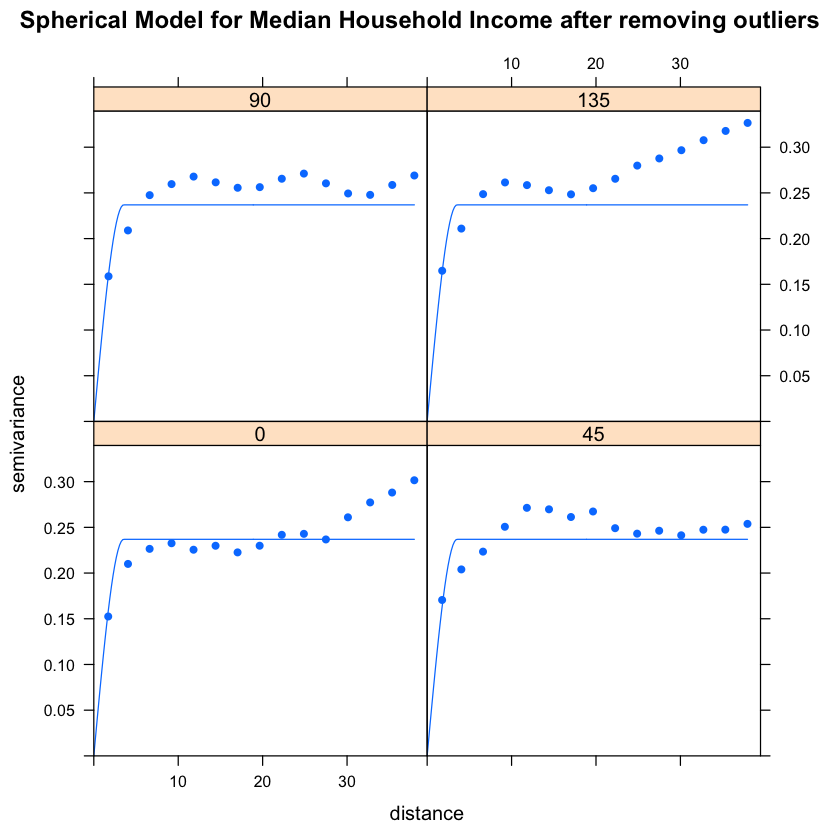

[using ordinary kriging]
[using ordinary kriging]


[1] "sph.cv <- gstat::krige.cv(MedHHinc~1, \n                          locations = censusBoundary.harris, \n                          model = mmhi_fit_sph) ## cross validation\nexp.cv <- gstat::krige.cv(MedHHinc~1, \n                          locations = censusBoundary.harris, \n                          model = mmhi_vgm_exp) ## cross validation\nmean(sph.cv$residual^2)\nmean(exp.cv$residual^2)"

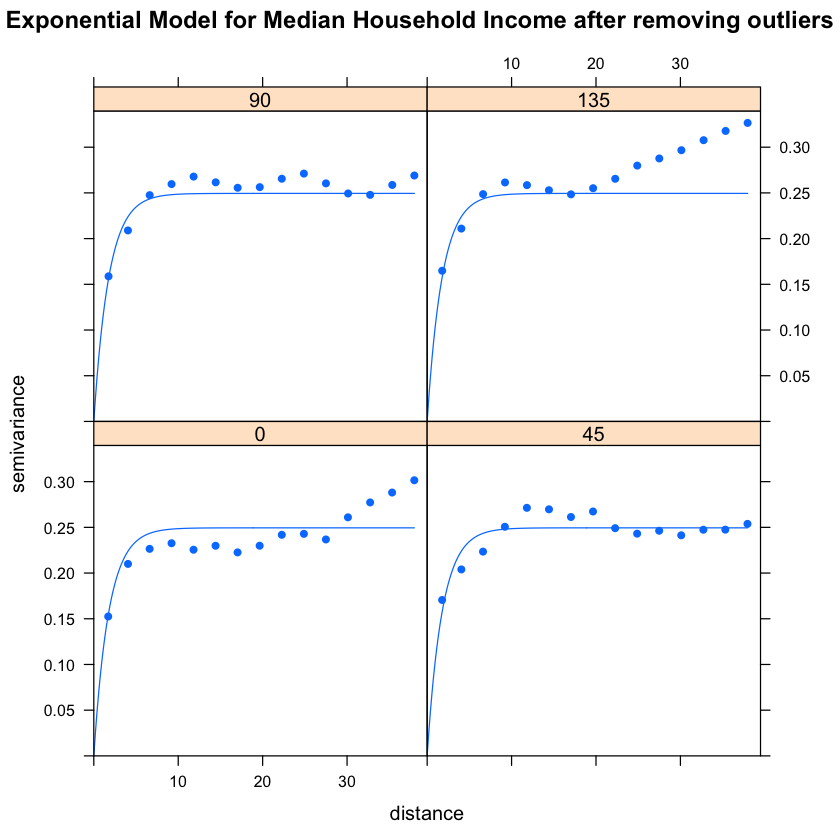

In [76]:
#spherical fit
mmhi_fit_sph <- gstat::fit.variogram(harris_vgm_rm_ol, 
                                      model = gstat::vgm(model =  "Sph"))
print(mmhi_fit_sph)
plot(harris_vgm_rm_ol, mmhi_fit_sph, main = "Spherical Model for Median Household Income after removing outliers", pch = 16)

#exponential fit
mmhi_vgm_exp <- gstat::fit.variogram(harris_vgm_rm_ol, model = gstat::vgm(model =  "Exp"))
print(mmhi_vgm_exp)
plot(harris_vgm_rm_ol, mmhi_vgm_exp, main = "Exponential Model for Median Household Income after removing outliers", pch = 16)


## kriging 

## spherical model

mmhi_krig_sph <- gstat::krige(MedHHinc~1, 
                              censusBoundary.harris_clean_rm_ol, 
                              census_grid, 
                              model = mmhi_fit_sph)

## exponential model

mmhi_krig_exp <- gstat::krige(MedHHinc~1, 
                              censusBoundary.harris_clean_rm_ol, 
                              census_grid, 
                              model = mmhi_vgm_exp)




Using ordinary kriging, fitting model with changing direction in plane (x,y) in positive 45 or 90 degrees clockwise from positive y (North) seems to be the best.

# Reference

American Community Survey (ACS) 2010. Urban Data Platform, Kinder Institute for Urban Research. https://www.kinderudp.org/#/datasetCatalog/8koe0a2ka4qb

SoS Notebook: An Interactive Multi-Language Data Analysis Environment. Bo Peng, Gao Wang, Jun Ma, Man Chong Leong, Chris Wakefield, James Melott, Yulun Chiu, Di Du, and John N. Weinstein, Bioinformatics, May 2018. doi: https://doi.org/10.1093/bioinformatics/bty405

Using R — Working with Geospatial Data (and ggplot2). Bethany Yollin http://mazamascience.com/WorkingWithData/?p=1494

How Spatial Autocorrelation: Moran's I (Spatial Statistics) works http://resources.esri.com/help/9.3/arcgisengine/java/gp_toolref/spatial_statistics_tools/how_spatial_autocorrelation_colon_moran_s_i_spatial_statistics_works.htm

Notes and code example from STAT 551.